In this notebook I will compare the above and below surface PAR measurements made in the Fraser plume to turbidity using a very simple model- assume that above surface PAR is S0, and below surface par is S0*(1-alpha). This may not be accurate. May need to account for reflected light due to spherical sensor; should probably talk to Rich about interpretation.

Also ignoring directionality; this is probably ok in very turbid waters but not in upper water column if turbidity is low

Model: 

$I=I_0(1-\alpha)\exp(-\int^0_z k(T,chl)dz)$

First try: $I_0$ is above surface PAR value, $k$ is from fit to turbidity and chlorophyll

In [1]:
import numpy as np
import os
import pandas as pd
from scipy import signal as ssig
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sys
sys.path.append('/ocean/eolson/MEOPAR/analysis-elise/notebooks/databases/')
import dataProcess2 as dpro
sys.path.append('/ocean/eolson/MEOPAR/analysis-elise/notebooks/PARModel/doc/')
import commonFuns2 as cf

In [2]:
df0=pd.read_csv('/ocean/eolson/MEOPAR/obs/FRSampling/stationsDigitized_v1.csv',header=0)
# FTU NTU fit without linear term
x=df0.loc[df0.ALS_Turb>0]['ALS_Turb'].values
x=x[:,np.newaxis]
a1=np.linalg.lstsq(x,df0.loc[df0.ALS_Turb>0]['sb19Turb'])[0]
FTUtoNTU=a1[0]
print(FTUtoNTU)

29.774349126467197


/home/eolson/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


In [3]:
basedir='/ocean/eolson/MEOPAR/obs/FRSampling/CTDdata/'
dir19='19-4561/4_derive'
dir25='25-0363/4_derive'
dir19T10='19-4561/4b_deriveTEOS10'
dir25T10='25-0363/4a_deriveTEOS10'
f19=dict()
f19[1]='fraser2017101.cnv'
f19[2]='fraser2017102.cnv'
f19[3]='fraser2017103.cnv'
f19[4]='fraser2017104.cnv'
f19[5]='fraser2017105.cnv'
f19[6]='fraser2017106.cnv'
f19[7]='fraser2017107.cnv'
f19[8]='fraser2017108.cnv'
f19[9]='fraser2017109.cnv'
f25=dict()
f25[1]='fraser2017001.cnv'
f25[2]='fraser2017002.cnv'
f25[3]='fraser2017003.cnv'
f25[4]='fraser2017004.cnv'
f25[5]='fraser2017005.cnv'
f25[6]='fraser2017006.cnv'
f25[7]='fraser2017007.cnv'
f25[8]='fraser2017008.cnv'
f25[9]='fraser2017009.cnv'
fpath19=dict()
fpath25=dict()
for ii in range(1,10):
    fpath19[ii]=os.path.join(basedir,dir19T10,f19[ii])
    fpath25[ii]=os.path.join(basedir,dir25T10,f25[ii])
cast19=dict()
cast25=dict()
for ii in range(1,10):
    cast19[ii]=dpro.Cast(fpath19[ii])
    cast25[ii]=dpro.Cast(fpath25[ii])

In [4]:
class zCast:
    def __init__(self,updf,downdf):
        self.uCast=updf
        self.dCast=downdf

In [5]:
zCasts=dict()
for nn in range(1,10):

    ip=np.argmax(cast25[nn].df['prSM'].values)
    ilag=df0.loc[df0.Station==nn,'ishift_sub19'].values[0]
    pS=df0.loc[df0.Station==nn,'pStart25'].values[0]
    pE=df0.loc[df0.Station==nn,'pEnd25'].values[0]

    dp=1.0
    pmax=cast25[nn].df.loc[ip,'prSM']
    edges=np.arange(dp/2,pmax+dp,dp)
    parDZ=.78
    xmisDZ=.36
    turbDZ=.67
    pshiftdict={'gsw_ctA0':0.0,'gsw_srA0':0.0,'xmiss':xmisDZ,'seaTurbMtr':turbDZ,'par':parDZ,
                'wetStar':0.0,'sbeox0ML_L':0.0}
    dCast=pd.DataFrame()
    uCast=pd.DataFrame()
    for var in ('gsw_ctA0','gsw_srA0','xmiss','par','wetStar','sbeox0ML_L'):
        #downcast
        inP=cast25[nn].df.loc[pS:ip]['prSM'].values-pshiftdict[var] # down p
        inV=cast25[nn].df.loc[pS:ip][var].values # down var
        p, out=dpro.bindepth(inP,inV,edges)
        if var=='gsw_ctA0':
            dCast=pd.DataFrame(p,columns=['prSM'])
        dCast[var]=out
        #upcast    
        inP=cast25[nn].df.loc[ip:pE]['prSM'].values-pshiftdict[var] # down p
        inV=cast25[nn].df.loc[ip:pE][var].values # down var
        p, out=dpro.bindepth(inP,inV,edges)
        if var=='gsw_ctA0':
            uCast=pd.DataFrame(p,columns=['prSM'])
        uCast[var]=out
    #turbidity downcast
    inP=cast25[nn].df.loc[pS:ip]['prSM'].values-turbDZ # down p
    inV=ssig.medfilt(cast19[nn].df.loc[(pS+ilag):(ip+ilag)]['seaTurbMtr'].values,3) # down var
    p, tur=dpro.bindepth(inP,inV,edges)
    dCast['turb']=tur
    dCast['NTU']=tur/FTUtoNTU
    #turbidity upcast
    inP=cast25[nn].df.loc[ip:pE]['prSM'].values-turbDZ # up p
    inV=ssig.medfilt(cast19[nn].df.loc[(ip+ilag):(pE+ilag)]['seaTurbMtr'].values,3) # up var
    p, tur=dpro.bindepth(inP,inV,edges)
    uCast['turb']=tur
    uCast['NTU']=tur/FTUtoNTU
    
    zCasts[nn]=zCast(uCast,dCast)
    
# fix first 2 casts for which sb25 pump did not turn on. use sb19
for nn in range(1,3):
    
    uCast=zCasts[nn].uCast
    dCast=zCasts[nn].dCast
    
    ip=np.argmax(cast25[nn].df['prSM'].values)
    ilag=df0.loc[df0.Station==nn,'ishift_sub19'].values[0]
    pS=df0.loc[df0.Station==nn,'pStart25'].values[0]
    pE=df0.loc[df0.Station==nn,'pEnd25'].values[0]

    dp=1.0
    pmax=cast25[nn].df.loc[ip,'prSM']
    edges=np.arange(dp/2,pmax+dp,dp)
    
    ##temperature
    #downcast
    inP=cast25[nn].df.loc[pS:ip]['prSM'].values # down p
    inV=cast19[nn].df.loc[(pS+ilag):(ip+ilag)]['gsw_ctA0'].values # down var
    p, out=dpro.bindepth(inP,inV,edges)
    dCast['gsw_ctA0']=out
    #upcast    
    inP=cast25[nn].df.loc[ip:pE]['prSM'].values # up p
    inV=cast19[nn].df.loc[(ip+ilag):(pE+ilag)]['gsw_ctA0'].values # up var
    p, out=dpro.bindepth(inP,inV,edges)
    uCast['gsw_ctA0']=out
    
    ##sal
    #downcast
    inP=cast25[nn].df.loc[pS:ip]['prSM'].values # down p
    inV=cast19[nn].df.loc[(pS+ilag):(ip+ilag)]['gsw_srA0'].values # down var
    p, out=dpro.bindepth(inP,inV,edges)
    dCast['gsw_srA0']=out
    #upcast    
    inP=cast25[nn].df.loc[ip:pE]['prSM'].values # up p
    inV=cast19[nn].df.loc[(ip+ilag):(pE+ilag)]['gsw_srA0'].values # up var
    p, out=dpro.bindepth(inP,inV,edges)
    uCast['gsw_srA0']=out
    
    ##xmiss: xmis25=1.14099414691*xmis19+-1.6910134322
    #downcast
    inP=cast25[nn].df.loc[pS:ip]['prSM'].values-xmisDZ # down p
    inV=1.14099414691*cast19[nn].df.loc[(pS+ilag):(ip+ilag)]['CStarTr0'].values-1.6910134322 # down var
    p, out=dpro.bindepth(inP,inV,edges)
    dCast['xmiss']=out
    #upcast    
    inP=cast25[nn].df.loc[ip:pE]['prSM'].values-xmisDZ # up p
    inV=1.14099414691*cast19[nn].df.loc[(ip+ilag):(pE+ilag)]['CStarTr0'].values-1.6910134322 # up var
    p, out=dpro.bindepth(inP,inV,edges)
    uCast['xmiss']=out
    
    uCast['wetStar']=np.nan
    dCast['wetStar']=np.nan
    uCast['sbeox0ML_L']=np.nan
    dCast['sbeox0ML_L']=np.nan
    
    zCasts[nn]=zCast(uCast,dCast)

In [6]:
# first make flattened dataframe, include only upcasts
dfulist=dict()
for nn in range(1,10):
    dfulist[nn]=zCasts[nn].uCast.copy()
    dfulist[nn]['isup']=1
    dfulist[nn]['sta']=nn
    dfulist[nn]['castid']=2*nn-1
dfall=dfulist[1].copy()
for nn in range(2,10):
    dfall=dfall.append(dfulist[nn], ignore_index=True)
dfall['cx']=cf.cXfromX(dfall['xmiss'])
dfall['NTU']=dfall['turb']/FTUtoNTU
dfall.head(30)

,prSM,gsw_ctA0,gsw_srA0,xmiss,par,wetStar,sbeox0ML_L,turb,NTU,isup,sta,castid,cx
0,1.0,6.306362,0.378850,2.932043,2.236695e+01,NaN,NaN,683.971251,22.971829,1,1,1,14.117883
1,2.0,6.310249,0.441165,2.934966,1.575302e+00,NaN,NaN,693.097651,23.278348,1,1,1,14.113897
2,3.0,6.316313,0.534918,2.945193,1.280958e-01,NaN,NaN,696.758534,23.401302,1,1,1,14.099983
3,4.0,6.320081,0.611985,3.032310,5.031213e-03,NaN,NaN,695.490190,23.358703,1,1,1,13.983382
4,5.0,6.322921,0.661319,3.033075,5.605485e-05,NaN,NaN,692.435405,23.256106,1,1,1,13.982373
5,6.0,6.325707,0.708888,3.037211,6.894603e-07,NaN,NaN,693.588406,23.294830,1,1,1,13.976922
6,7.0,6.330148,0.759324,3.016734,1.526496e-08,NaN,NaN,696.937555,23.407315,1,1,1,14.003982
7,8.0,6.343009,0.934182,2.863257,4.787687e-10,NaN,NaN,707.453677,23.760509,1,1,1,14.212841
8,9.0,6.353453,1.145314,2.842351,3.901169e-12,NaN,NaN,706.430689,23.726151,1,1,1,14.242155
9,10.0,6.360641,1.273424,2.799797,1.490007e-12,NaN,NaN,721.138050,24.220111,1,1,1,14.302492


In [7]:
ctochl=0.04033208 # from fitTofXF-newApproach-no321-Figs.ipynb
turbfit=[ 1.63835959, 0.02880713,-0.03110628] # from fitTofXF-newApproach-no321-Figs.ipynb
PARfit=[ 0.15007826,  0.03342053,  0.14269878]# from fitTofXF-newApproach-no321-Figs.ipynb resfitW.x
dfall['cI']=dfall['cx']-ctochl*dfall['wetStar']


In [8]:
data=list()
FLarrays=list()
dzarrays=list()
for i, row in dfall.iterrows():
    stID=row['castid']
    iData=dfall.loc[(dfall.castid==stID)&(dfall.par>0)&(dfall.NTU>0)&(dfall.wetStar>0)&(dfall.cx>0)].copy()
    if len(iData)>1:
        dftest=iData.sort_values(by=['prSM']).copy()
        dftest['cX']=dftest['cx']
        dftest['Depth']=dftest['prSM']
        iii=0
        cXInt=0.0
        FLInt=0.0
        iFLarray=list()
        NTUInt=0.0
        idzarray=list()
        statmax=np.max(dftest['NTU'])
        for drow in dftest.itertuples():
            if iii==0:
                I0=drow.par
                z0=drow.Depth
                lastcX=drow.cX
                lastz=drow.Depth
                lastPAR=drow.par
                lastFL=drow.wetStar
                lastNTU=drow.NTU
                iFLarray.append(lastFL)
            else:
                PAR=drow.par
                delz=drow.Depth-z0
                cX=drow.cX
                cXInt+=0.5*(lastcX+cX)*(drow.Depth-lastz)
                NTU=drow.NTU
                NTUInt+=0.5*(lastNTU+NTU)*(drow.Depth-lastz)
                FL=drow.wetStar
                FLInt+=0.5*(lastFL+FL)*(drow.Depth-lastz)
                idzarray.append(drow.Depth-lastz)
                iFLarray.append(FL)
                data.append((stID, drow.Depth, delz, PAR, lastPAR, I0, NTU, NTUInt, FL, FLInt,statmax,drow.Depth-lastz))
                FLarrays.append(np.array(iFLarray))
                dzarrays.append(np.array(idzarray))
                lastcX=cX
                lastPAR=PAR
                lastz=drow.Depth
                lastFL=drow.wetStar
                lastNTU=drow.NTU
                # now add calcs to list
            iii+=1

In [9]:
dfFR=pd.DataFrame(data,columns=['stID', 'z', 'Delz', 'I', 'lastI','I0', 'NTU', 'NTUInt', 
                                   'FL','FLInt','statmax','idz'])
dfFR['dzarrays']=dzarrays
dfFR['FLarrays']=FLarrays
dfFR.tail()

,stID,z,Delz,I,lastI,I0,NTU,NTUInt,FL,FLInt,statmax,idz,dzarrays,FLarrays
40707,17.0,5.0,3.0,7.203329,11.685732,58.491073,1.326573,8.333822,3.036971,9.674018,6.411987,1.0,"[1.0, 1.0, 1.0]","[3.573160783341596, 3.2982636276977177, 3.0706..."
40708,17.0,6.0,4.0,4.845538,7.203329,58.491073,0.807924,9.401070,2.909846,12.647426,6.411987,1.0,"[1.0, 1.0, 1.0, 1.0]","[3.573160783341596, 3.2982636276977177, 3.0706..."
40709,17.0,7.0,5.0,3.389925,4.845538,58.491073,0.747902,10.178983,2.788304,15.496501,6.411987,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]","[3.573160783341596, 3.2982636276977177, 3.0706..."
40710,17.0,8.0,6.0,2.486289,3.389925,58.491073,0.790423,10.948145,2.578223,18.179765,6.411987,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[3.573160783341596, 3.2982636276977177, 3.0706..."
40711,17.0,9.0,7.0,1.880899,2.486289,58.491073,0.901461,11.794087,2.582733,20.760243,6.411987,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[3.573160783341596, 3.2982636276977177, 3.0706..."


In [10]:
def I1(b,I0,Tint,Fint,delz):
    return I0*np.exp(-(b[0]*Tint+b[1]*Fint+b[2]*delz))

In [11]:
def Ifixed(b,I0,Tint,FLarrays,dzarrays,delz,const):
# k=b[0]*T+b[1]*F^0.65+b[2]
    Fint=np.zeros(np.shape(I0))
    for ii in range(0,len(I0)):
        Fs=np.power(FLarrays[ii],const)
        ds=dzarrays[ii]
        Fint[ii]=np.sum(0.5*(Fs[1:]+Fs[:-1])*ds)
    return I1(b,I0,Tint,Fint,delz)

In [12]:
IestFR=Ifixed(PARfit,dfFR['I0'],dfFR['NTUInt'],dfFR['FLarrays'],dfFR['dzarrays'],dfFR['Delz'],0.665)

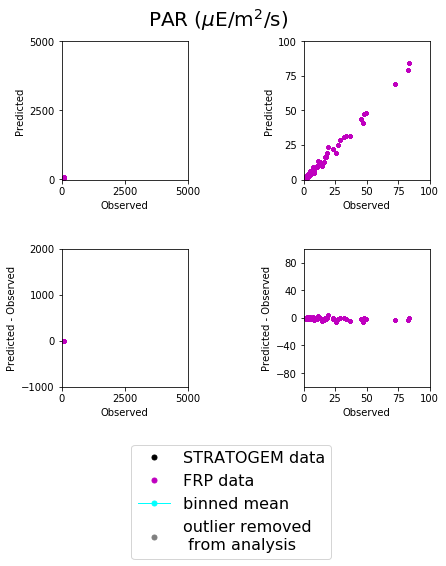

In [13]:
fig,ax=plt.subplots(2,2,figsize=(7,8))

ax[0,0].set_xlabel('Observed')
ax[0,0].set_ylabel('Predicted')
ax[1,0].set_xlabel('Observed')
ax[1,0].set_ylabel('Predicted - Observed')
bins=np.arange(-10,3.8,.2)
bins=np.power(10,bins)
ff=np.nan*np.zeros(len(bins)-1)

ax[0,1].set_xlabel('Observed')
ax[0,1].set_ylabel('Predicted')
ax[1,1].set_xlabel('Observed')
ax[1,1].set_ylabel('Predicted - Observed')
ax[0,1].set_xlim(0,100)
ax[0,1].set_ylim(0,100)
ax[1,1].set_xlim(0,100)
ax[1,1].set_ylim(-100,100)

ax[0,0].plot(dfFR['I'],IestFR,'m.')
ax[0,1].plot(dfFR['I'],IestFR,'m.')
ax[1,0].plot(dfFR['I'],IestFR-dfFR['I'],'m.')
ax[1,1].plot(dfFR['I'],IestFR-dfFR['I'],'m.')
ax[1,1].plot(0.5*(bins[1:]+bins[:-1]),ff,'c.-')
ax[1,0].plot(0.5*(bins[1:]+bins[:-1]),ff,'c.-')
plt.suptitle('PAR ($\mu$E/m$^2$/s)',fontsize=20)

ax[0,0].set_position([.19,.68,.25,.24])
ax[0,1].set_position([.67,.68,.25,.24])
ax[1,0].set_position([.19,.32,.25,.24])
ax[1,1].set_position([.67,.32,.25,.24])

ax[0,0].set_xticks([0,2500,5000])
ax[0,0].set_yticks([0,2500,5000])
ax[0,1].set_xticks([0,25,50,75,100])
ax[0,1].set_yticks([0,25,50,75,100])
ax[1,0].set_xticks([0,2500,5000])
ax[1,0].set_yticks([-1000,0,1000,2000])
ax[1,1].set_xticks([0,25,50,75,100])
ax[1,1].set_yticks([-80,-40,0,40,80])

cpatch = mlines.Line2D([], [], color='k', marker='.',linewidth=0,
                          markersize=10, label='STRATOGEM data')
opatch2=mlines.Line2D([], [], color='m', marker='.',linewidth=0,
                          markersize=10, label='FRP data')
opatch=mlines.Line2D([], [], color='cyan', marker='.',linewidth=1,
                          markersize=10, label='binned mean')
cpatch2 = mlines.Line2D([], [], color='gray', marker='.',linewidth=0,
                          markersize=10, label='outlier removed\n from analysis')

ax[1,1].legend(handles=[cpatch,opatch2,opatch, cpatch2],fontsize=16,
          loc='center left', bbox_to_anchor=(-1.43,-.83))


In [14]:
dfall

,prSM,gsw_ctA0,gsw_srA0,xmiss,par,wetStar,sbeox0ML_L,turb,NTU,isup,sta,castid,cx,cI
0,1.0,6.306362,0.378850,2.932043,22.366952,NaN,NaN,683.971251,22.971829,1,1,1,14.117883,NaN
1,2.0,6.310249,0.441165,2.934966,1.575302,NaN,NaN,693.097651,23.278348,1,1,1,14.113897,NaN
2,3.0,6.316313,0.534918,2.945193,0.128096,NaN,NaN,696.758534,23.401302,1,1,1,14.099983,NaN
3,4.0,6.320081,0.611985,3.032310,0.005031,NaN,NaN,695.490190,23.358703,1,1,1,13.983382,NaN
4,5.0,6.322921,0.661319,3.033075,0.000056,NaN,NaN,692.435405,23.256106,1,1,1,13.982373,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,6.0,8.461619,28.941611,88.403628,4.845538,2.909846,5.920872,24.055398,0.807924,1,9,17,0.493029,0.375669
522,7.0,8.450261,29.030104,88.797121,3.389925,2.788304,5.900716,22.268289,0.747902,1,9,17,0.475264,0.362806
523,8.0,8.428270,29.098182,88.228878,2.486289,2.578223,5.830338,23.534333,0.790423,1,9,17,0.500943,0.396958
524,9.0,8.402681,29.175696,87.161750,1.880899,2.582733,5.753383,26.840415,0.901461,1,9,17,0.549618,0.445451


In [15]:
dfall.sta.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
iData=dfall.loc[(dfall.par>0)&(dfall.NTU>0)&(dfall.wetStar>0)&(dfall.cx>0)]
df2=iData.loc[iData.groupby('sta')['prSM'].idxmin()].copy().reset_index()

In [17]:
df2

,index,prSM,gsw_ctA0,gsw_srA0,xmiss,par,wetStar,sbeox0ML_L,turb,NTU,isup,sta,castid,cx,cI
0,15,2.0,8.543935,26.549350,73.064357,138.764095,15.731240,7.097734,46.828105,1.572767,1,3,5,1.255318,0.620844
1,109,2.0,8.865902,25.576685,65.315289,157.670271,13.307427,7.302243,63.735691,2.140624,1,4,7,1.703776,1.167060
2,203,2.0,8.170067,20.415817,36.666633,78.632432,21.413492,7.026692,183.923766,6.177256,1,5,9,4.013212,3.149561
3,277,2.0,8.479140,23.589314,45.671501,87.404665,20.116985,6.757368,147.710000,4.960982,1,6,11,3.134783,2.323423
4,362,2.0,8.717070,25.642876,60.272761,89.618532,7.686684,6.332582,105.770071,3.552389,1,7,13,2.025160,1.715140
5,443,2.0,8.603297,27.228973,71.715648,118.588406,3.767318,6.179902,66.313258,2.227194,1,8,15,1.329845,1.177901
6,517,2.0,8.085326,20.379248,39.330193,58.491073,3.573161,6.583232,190.912726,6.411987,1,9,17,3.732711,3.588598


In [18]:
# figure out what above surface value was: Iplus; FRPSampling_v1-exp1-Copy1
# station 3: 1380
# station 4: 1376
# station 5: 2376
# station 6: 2830
# station 7: 1532
# station 8: 2189
# station 9: 2677
df2['parOut']=(1380,1376,2376,2830,1532,2189,2677)
df2['k']=PARfit[0]*df2['NTU']+PARfit[1]*df2['wetStar']+PARfit[2]

Text(0, 0.5, 'I(2m)/I+')

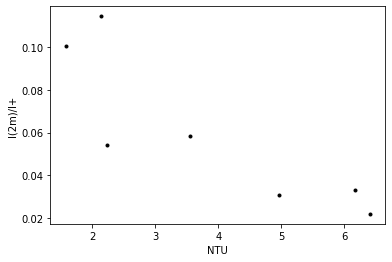

In [19]:
plt.plot(df2['NTU'],df2['par']/df2['parOut'],'k.')
plt.xlabel('NTU')
plt.ylabel('I(2m)/I+')

Text(0, 0.5, 'alpha')

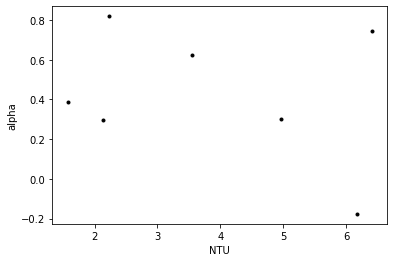

In [20]:
# I(2m)=(1-alpha)I(+)exp(-kz), PAR above = I
plt.plot(df2['NTU'],1-df2['par']*np.exp(2*df2['k'])/df2['parOut'],'k.')
plt.xlabel('NTU')
plt.ylabel('alpha')

Text(0, 0.5, 'alpha')

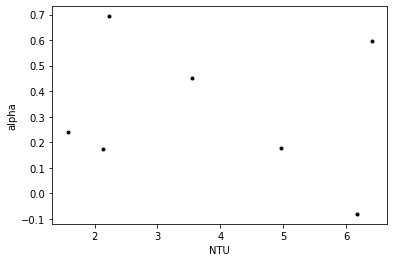

In [21]:
# I(2m)=(1-alpha)I(+)exp(-kz), PAR above = I(1+alpha)
A=df2['par']*np.exp(2*df2['k'])/df2['parOut']
plt.plot(df2['NTU'],(1-A)/(1+A),'k.')
plt.xlabel('NTU')
plt.ylabel('alpha')

In [25]:
df2['k']

0    0.904483
1    0.908701
2    1.785421
3    1.559555
4    0.932728
5    0.602858
6    1.224415
Name: k, dtype: float64

In [26]:
np.exp(-2*df2['k']) # I(2m)/I(-)

0    0.163823
1    0.162447
2    0.028132
3    0.044197
4    0.154826
5    0.299478
6    0.086395
Name: k, dtype: float64

In [27]:
PARfit

[0.15007826, 0.03342053, 0.14269878]

In [28]:
# at each depth have PAR measurement; 
# could integrate k up to surface from each depth to get subsurface estimate, 
# see if error is reduced